## Installation

In [1]:
%%capture
!git lfs install
!git clone https://huggingface.co/Cene655/Imagen-pytorch

In [2]:
%%capture
!pip install git+https://github.com/cene555/Imagen-pytorch.git
!pip install git+https://github.com/openai/CLIP.git

In [3]:
%%capture
!git clone https://github.com/xinntao/Real-ESRGAN.git

In [4]:
%cd Real-ESRGAN

/content/Real-ESRGAN


In [5]:
%%capture
!pip install basicsr
# facexlib and gfpgan are for face enhancement
!pip install facexlib
!pip install gfpgan

In [6]:
%%capture
!pip install -r requirements.txt
!python setup.py develop
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

## Imports 

In [7]:
from PIL import Image
from IPython.display import display
import torch as th
from imagen_pytorch.model_creation import create_model_and_diffusion as create_model_and_diffusion_dalle2
from imagen_pytorch.model_creation import model_and_diffusion_defaults as model_and_diffusion_defaults_dalle2
from transformers import AutoTokenizer
import clip
import cv2

import glob
import os
from basicsr.archs.rrdbnet_arch import RRDBNet

from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact
from gfpgan import GFPGANer

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

## Setting Up

In [8]:
def model_fn(x_t, ts, **kwargs):
    guidance_scale = 3
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

In [9]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline."""
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [10]:
def get_numpy_img(img):
    scaled = ((img + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([img.shape[2], -1, 3])
    return cv2.cvtColor(reshaped.numpy(), cv2.COLOR_BGR2RGB)

In [11]:
options = model_and_diffusion_defaults_dalle2()
options['use_fp16'] = False
options['diffusion_steps'] = 200
options['num_res_blocks'] = 3

model, diffusion = create_model_and_diffusion_dalle2(**options)
model.eval()

#if has_cuda:
#    model.convert_to_fp16()

model.to(device)
model.load_state_dict(th.load('/content/Imagen-pytorch/imagen-pytorch.pt'))
print('total base parameters', sum(x.numel() for x in model.parameters()))

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.20.layer.1.EncDecAttention.q.weight', 'decoder.block.22.layer.2.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.1.layer.1.layer_norm.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.6.layer.0.layer_norm.weight', 'decoder.block.18.layer.2.DenseReluDense.wo.weight', 'decoder.block.11.layer.0.SelfAttention.k.weight', 'decoder.block.2.layer.2.DenseReluDense.wi.weight', 'decoder.block.21.layer.1.layer_norm.weight', 'decoder.block.12.layer.0.SelfAttention.q.weight', 'decoder.block.6.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.13.layer.1.EncDecAttention.q.weight', 'decoder.block.18.layer.2.DenseReluDense.wi.weight', 'decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.12.layer.1.EncDecAttention.o.weight'

total base parameters 644586566


In [12]:
num_params = sum(param.numel() for param in model.parameters())
num_params

644586566

In [13]:
realesrgan_model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64,
                           num_block=23, num_grow_ch=32, scale=4)

In [14]:
netscale = 4

In [15]:
upsampler = RealESRGANer(
    scale=netscale,
    model_path='/content/Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth',
    model=realesrgan_model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True
)

In [16]:
face_enhancer = GFPGANer(
    model_path='https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth',
    upscale=4,
    arch='clean',
    channel_multiplier=2,
    bg_upsampler=upsampler
)

Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /usr/local/lib/python3.7/dist-packages/facexlib/weights/detection_Resnet50_Final.pth



  0%|          | 0.00/104M [00:00<?, ?B/s]

Downloading: "https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth" to /usr/local/lib/python3.7/dist-packages/gfpgan/weights/GFPGANv1.3.pth



  0%|          | 0.00/332M [00:00<?, ?B/s]

In [17]:
tokenizer = AutoTokenizer.from_pretrained(options['t5_name'])

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [18]:
#@title What do you want to generate?

prompt = 'value' #@param {type:"string"}

In [19]:
text_encoding = tokenizer(
    prompt,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

uncond_text_encoding = tokenizer(
    '',
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [20]:
model_kwargs = {}
model_kwargs["tokens"] = th.cat((text_encoding['input_ids'],
                                 uncond_text_encoding['input_ids'])).to(device)
model_kwargs["mask"] = th.cat((text_encoding['attention_mask'],
                               uncond_text_encoding['attention_mask'])).to(device)

## Generation

In [21]:
sample = diffusion.p_sample_loop(
    model_fn,
    (2, 3, 64, 64),
    clip_denoised=True,
    model_kwargs=model_kwargs,
    device='cuda',
    progress=True,
)[:1]

  0%|          | 0/200 [00:00<?, ?it/s]

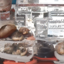

In [22]:
show_images(sample)

In [23]:
%%time
new_img = get_numpy_img(sample)
for i in range(1):
    _, _, new_img = face_enhancer.enhance(new_img, has_aligned=False,
                                          only_center_face=False, paste_back=True)

CPU times: user 110 ms, sys: 4.57 ms, total: 114 ms
Wall time: 256 ms


In [24]:
cv2.imwrite('/content/test_out.jpg', new_img)

True